<a href="https://colab.research.google.com/github/DkMaria/Fake-News-Detection/blob/main/BERT_UNDER_FN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pytorch_pretrained_bert pytorch-nlp

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# verify GPU availability
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
pip install transformers

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
import torch.utils.data as data_utils
import torch.optim as optim
import gc #garbage collector for gpu memory 
from tqdm import tqdm
from collections import Counter
from sklearn.metrics import classification_report
import transformers
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from pytorch_pretrained_bert import BertTokenizer
from keras.preprocessing.sequence import pad_sequences
from pytorch_pretrained_bert import BertModel

In [ ]:
# read csv files which contains all TRUE claims
true = pd.read_csv('/content/drive/MyDrive/true28.csv', delimiter=",")
df_true = pd.DataFrame(true, columns=['headline', 'text', 'keywords', 'datePublished', 'ratingName'])
print('TRUE: ', df_true)
print(len(df_true)) # 4448
print(df_true.head())

# read csv files which contains all FALSE claims
false = pd.read_csv('/content/drive/MyDrive/false05.csv', delimiter=",", encoding='mac_roman')
df_false = pd.DataFrame(false, columns=['headline', 'text', 'keywords', 'datePublished', 'ratingName'])
print('FALSE: ', df_false)
print(len(df_false)) # 
print(df_false.head())

df_true['label'] = 0
df_false['label'] = 1
data = pd.concat([df_true, df_false])
labels = data['label']

# shuffle the dataset
data = data.sample(frac=1)

target = data['label'].values

TRUE:                                                 headline  ... ratingName
0                   Fiorina: Trump's abortion flip-flop  ...       True
1     Sean Hannity says Barack Obama's jobs bill cre...  ...       True
2                          ""Executive"" makes it right  ...       True
3                 Chase Bank Won’t Allow Cash Deposits?  ...       True
4                            Shackelford Prayer Request  ...       True
...                                                 ...  ...        ...
4108                                        Moose Story  ...       True
4109  Rand Paul says federal spending has risen to 2...  ...       True
4110                                    Vieques Closure  ...       True
4111          DeKalb CEO says he wields a big budget ax  ...       True
4112               Dewitos: Doritos Flavor Mountain Dew  ...       True

[4113 rows x 5 columns]
4113
                                            headline  ... ratingName
0                Fiorina: Trum

Counter({False: 10000, True: 4113})
true 0: (4113, 6)
false 1: (10000, 6)
total class of 1 and 0: 1    4113
0    4113
Name: label, dtype: int64


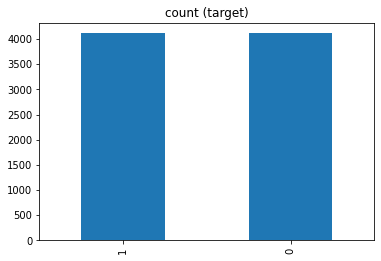

In [ ]:
print(Counter(data['ratingName'].values))

# class count
true_count, false_count = data['label'].value_counts()

# Separate class
true = data[data['label'] == 0] #true claims
false = data[data['label'] == 1]# print the shape of the class #false claims
print('true 0:', true.shape)
print('false 1:', false.shape)


'''Undersampling can be defined as removing some observations of the majority class. This is done until the majority and 
minority class is balanced out'''
false_under = false.sample(false_count)
#print(class_1_under)

test_under = pd.concat([false_under, true], axis=0)

print("total class of 1 and 0:",test_under['label'].value_counts())# plot the count after under-sampeling
test_under['label'].value_counts().plot(kind='bar', title='count (target)')

In [ ]:
target = test_under['label']
data = test_under.sample(frac=1)

In [ ]:
x_train, X_test, y_train, y_test = train_test_split(test_under['text'], target, test_size =0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(x_train, y_train, test_size =0.10, random_state=42)
print('Size training set: ',len(x_train))
print('Size validation set: ', len(X_val))
print('Size test set: ', len(X_test))

Size training set:  6580
Size validation set:  658
Size test set:  1646


In [ ]:
train_txts = X_train
train_lbels = y_train

test_txts = X_test
test_lbels = y_test

val_txts = X_val
val_lbels = y_val 

In [ ]:
len(train_txts), len(train_lbels), len(test_txts), len(test_lbels), len(val_txts), len(val_lbels)

(5922, 5922, 1646, 1646, 658, 658)

In [ ]:
# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

100%|██████████| 231508/231508 [00:00<00:00, 1853969.99B/s]


In [ ]:
train_tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:511], train_txts))
test_tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:511], test_txts))
val_tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:511], val_txts))

In [ ]:
'''Convert each token in each news to an id as present in the tokenizer vocabulary. If there’s a 
   token that is not present in the vocabulary, the tokenizer will use the special [UNK] token and
   use its id'''
train_tokens_ids = list(map(tokenizer.convert_tokens_to_ids, train_tokens))
test_tokens_ids = list(map(tokenizer.convert_tokens_to_ids, test_tokens))
val_tokens_ids = list(map(tokenizer.convert_tokens_to_ids, val_tokens))

In [ ]:
'''we need to pad our input so it will have the same size of 512. It means that for any review that 
   is shorter than 512 tokens, we’ll add zeros to reach 512 tokens'''

train_tokens_ids = pad_sequences(train_tokens_ids, maxlen=512, truncating="post", padding="post", dtype="int")
test_tokens_ids = pad_sequences(test_tokens_ids, maxlen=512, truncating="post", padding="post", dtype="int")
val_tokens_ids = pad_sequences(val_tokens_ids, maxlen=512, truncating="post", padding="post", dtype="int")

In [ ]:
'''Our target variable is currently a list of 0 and 1. We’ll convert it to numpy arrays of
   booleans'''

train_y = np.array(train_lbels) 
test_y = np.array(test_lbels)
val_y = np.array(val_lbels)

In [ ]:
'''Create our BERT classifier which contains an ‘initialization’ method and a ‘forward’ method that 
   returns token probabilities'''
class BertBinaryClassifier(nn.Module):
    def __init__(self, dropout=0.1):
        super(BertBinaryClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-uncased')

        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, tokens, masks=None):
        _, pooled_output = self.bert(tokens, attention_mask=masks, output_all_encoded_layers=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        proba = self.sigmoid(linear_output)
        return proba

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
str(torch.cuda.memory_allocated(device)/1000000 ) + 'M'

'0.0M'

In [ ]:
bert_clf = BertBinaryClassifier()
bert_clf = bert_clf.cuda()

100%|██████████| 407873900/407873900 [00:10<00:00, 38000575.10B/s]


In [ ]:
str(torch.cuda.memory_allocated(device)/1000000 ) + 'M'

'439.065088M'

In [ ]:
x = torch.tensor(train_tokens_ids[:3]).to(device)
y, pooled = bert_clf.bert(x, output_all_encoded_layers=False)
x.shape, y.shape, pooled.shape

(torch.Size([3, 512]), torch.Size([3, 512, 768]), torch.Size([3, 768]))

In [ ]:
y, x, pooled = None, None, None
torch.cuda.empty_cache()
str(torch.cuda.memory_allocated(device)/1000000 ) + 'M'

'3568.20736M'

In [ ]:
BATCH_SIZE = 4
EPOCHS = 10

In [ ]:
'''Generate training-testing-validation masks'''
train_masks = [[float(i > 0) for i in ii] for ii in train_tokens_ids]
train_masks_tensor = torch.tensor(train_masks)

test_masks = [[float(i > 0) for i in ii] for ii in test_tokens_ids]
test_masks_tensor = torch.tensor(test_masks)

val_masks = [[float(i > 0) for i in ii] for ii in val_tokens_ids]
val_masks_tensor = torch.tensor(val_masks)

'''Generate token tensors for training-testing-validation'''
train_tokens_tensor = torch.tensor(train_tokens_ids)
train_y_tensor = torch.tensor(train_y.reshape(-1, 1)).float()

test_tokens_tensor = torch.tensor(test_tokens_ids)
test_y_tensor = torch.tensor(test_y.reshape(-1, 1)).float()

val_tokens_tensor = torch.tensor(val_tokens_ids)
val_y_tensor = torch.tensor(val_y.reshape(-1, 1)).float()

'''Prepare data loaders'''
train_dataset =  torch.utils.data.TensorDataset(train_tokens_tensor, train_masks_tensor, train_y_tensor)
train_sampler =  torch.utils.data.RandomSampler(train_dataset)
train_dataloader =  torch.utils.data.DataLoader(train_dataset, sampler=train_sampler, batch_size=BATCH_SIZE)

test_dataset =  torch.utils.data.TensorDataset(test_tokens_tensor, test_masks_tensor, test_y_tensor)
test_sampler =  torch.utils.data.SequentialSampler(test_dataset)
test_dataloader =  torch.utils.data.DataLoader(test_dataset, sampler=test_sampler, batch_size=BATCH_SIZE)

val_dataset =  torch.utils.data.TensorDataset(val_tokens_tensor, val_masks_tensor, val_y_tensor)
val_sampler =  torch.utils.data.SequentialSampler(val_dataset)
val_dataloader =  torch.utils.data.DataLoader(val_dataset, sampler=val_sampler, batch_size=BATCH_SIZE)

In [ ]:
param_optimizer = list(bert_clf.sigmoid.named_parameters()) 
optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

In [ ]:
from torch.optim import Adam

optimizer = Adam(bert_clf.parameters(), lr=3e-6)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

Η έξοδος ροής περικόπηκε στις τελευταίες 5000 γραμμές.
Epoch:  9
1295/1480.5 loss: 0.039775910056409944 
1768.410624M
Epoch:  9
1296/1480.5 loss: 0.03974709427841374 
1768.410624M
Epoch:  9
1297/1480.5 loss: 0.03972258613202168 
1768.410624M
Epoch:  9
1298/1480.5 loss: 0.039810882318788945 
1768.410624M
Epoch:  9
1299/1480.5 loss: 0.039781074573312744 
1768.410624M
Epoch:  9
1300/1480.5 loss: 0.039847868395857244 
1768.410624M
Epoch:  9
1301/1480.5 loss: 0.03981846329532013 
1768.410624M
Epoch:  9
1302/1480.5 loss: 0.04009101463849703 
1768.410624M
Epoch:  9
1303/1480.5 loss: 0.04039301011371933 
1768.410624M
Epoch:  9
1304/1480.5 loss: 0.04036267430836449 
1768.410624M
Epoch:  9
1305/1480.5 loss: 0.04036119514310577 
1768.410624M
Epoch:  9
1306/1480.5 loss: 0.04033199908941672 
1768.410624M
Epoch:  9
1307/1480.5 loss: 0.040783224812545385 
1768.410624M
Epoch:  9
1308/1480.5 loss: 0.04075272027933166 
1768.410624M
Epoch:  9
1309/1480.5 loss: 0.04072273618618083 
1768.410624M
Epoch:  9


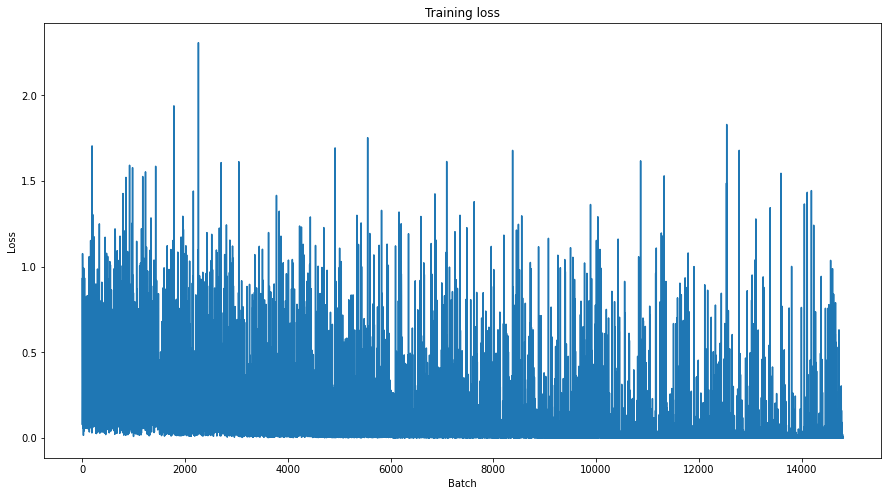

In [ ]:
import matplotlib.pyplot as plt
# Store our loss and accuracy for plotting
train_loss_set = []
for epoch_num in range(EPOCHS):
    bert_clf.train()
    train_loss = 0
    for step_num, batch_data in enumerate(train_dataloader):
        token_ids, masks, labels = tuple(t.to(device) for t in batch_data)
        print(str(torch.cuda.memory_allocated(device)/1000000 ) + 'M')
        logits = bert_clf(token_ids, masks)        
        loss_func = nn.BCELoss()
        batch_loss = loss_func(logits, labels)
        train_loss_set.append(batch_loss.item())  
        train_loss += batch_loss.item()
        bert_clf.zero_grad()
        batch_loss.backward()        
        #clip_grad_norm_(parameters=bert_clf.parameters(), max_norm=1.0)
        optimizer.step()
        #clear_output(wait=True)
        print('Epoch: ', epoch_num + 1)
        print("\r" + "{0}/{1} loss: {2} ".format(step_num, len(X_train) / BATCH_SIZE, train_loss / (step_num + 1)))

# plot training performance
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

In [ ]:
for epoch_num in range(EPOCHS):
  # Put model in evaluation mode
 bert_clf.eval()
 # Tracking variables 
 eval_loss, eval_accuracy = 0, 0
 nb_eval_steps, nb_eval_examples = 0, 0
 # Evaluate data for one epoch
 for batch in val_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
   # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up validation
  with torch.no_grad():
        # Forward pass, calculate logit predictions
    logits = bert_clf(token_ids, masks)    
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1
    print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

In [ ]:
bert_clf.eval()
bert_predicted = []
all_logits = []
with torch.no_grad():
    for step_num, batch_data in enumerate(test_dataloader):

        token_ids, masks, labels = tuple(t.to(device) for t in batch_data)

        logits = bert_clf(token_ids, masks)
        loss_func = nn.BCELoss()
        loss = loss_func(logits, labels)
        numpy_logits = logits.cpu().detach().numpy()
        
        bert_predicted += list(numpy_logits[:, 0] > 0.5)
        all_logits += list(numpy_logits[:, 0])

In [ ]:
np.mean(bert_predicted)

0.43438639125151884

In [ ]:
target_names = ['real_news', 'fake_news']
print(classification_report(test_y, bert_predicted, target_names = target_names))

              precision    recall  f1-score   support

   real_news       0.71      0.81      0.75       816
   fake_news       0.78      0.67      0.72       830

    accuracy                           0.74      1646
   macro avg       0.74      0.74      0.74      1646
weighted avg       0.74      0.74      0.74      1646



   real_news       0.71      0.81      0.75       816
['real_news', '0.71', '0.81', '0.75', '816']
[0.71, 0.81, 0.75]
   fake_news       0.78      0.67      0.72       830
['fake_news', '0.78', '0.67', '0.72', '830']
[0.78, 0.67, 0.72]


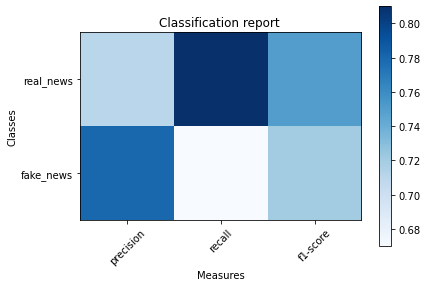

In [ ]:
import numpy as np

def plot_classification_report(cr, title='Classification report ', with_avg_total=False, cmap=plt.cm.Blues):

    lines = cr.split('\n')

    classes = []
    plotMat = []
    for line in lines[2 : (len(lines) - 5)]:
        print(line)
        t = line.split()
        print(t)
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        print(v)
        plotMat.append(v)

    if with_avg_total:
        aveTotal = lines[len(lines) - 1].split()
        classes.append('avg/total')
        vAveTotal = [float(x) for x in t[1:len(aveTotal) - 1]]
        plotMat.append(vAveTotal)


    plt.imshow(plotMat, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    x_tick_marks = np.arange(3)
    y_tick_marks = np.arange(len(classes))
    plt.xticks(x_tick_marks, ['precision', 'recall', 'f1-score'], rotation=45)
    plt.yticks(y_tick_marks, classes)
    plt.tight_layout()
    plt.ylabel('Classes')
    plt.xlabel('Measures')


ClassificationReport = classification_report(test_y, bert_predicted, target_names = target_names)
plot_classification_report(ClassificationReport)